In [10]:
import miniFasta as mf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
seq_file = "hg38.fasta"
mask_file = "mask.fasta"

In [12]:
# Read sequences and mask annotations
seqs = list(mf.read(seq_file)) # List of sequence strings
masks = list(mf.read(mask_file)) # List of mask strings (0/1)
print(seqs[0].head)
print(seqs[0].body[:30])

>chr1
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


In [13]:
# Build DataFrame from miniFasta records and compute metrics
# Validate record counts
assert len(seqs) == len(masks), f"Mismatch between sequences ({len(seqs)}) and masks ({len(masks)})"

# Extract headers and bodies
headers = [r.head for r in seqs]
seq_strs = [r.body for r in seqs]
mask_strs = [r.body for r in masks]

# Ensure per-record sequence/mask lengths match
length_mismatch = [(i, len(s), len(m)) for i, (s, m) in enumerate(zip(seq_strs, mask_strs)) if len(s) != len(m)]
assert len(length_mismatch) == 0, f"Found {len(length_mismatch)} sequence/mask length mismatches, e.g. first: {length_mismatch[0]}"

# Helper to extract chromosome from FASTA header
def extract_chr(header: str) -> str:
    tok = header.split()[0]
    idx = tok.find("chr")
    if idx != -1:
        rest = tok[idx:]
        for sep in (":", "|", "/", "\\", ",", ";"):
            if sep in rest:
                rest = rest.split(sep)[0]
        return rest
    return tok.split(":")[0]

# Build dataframe
df = pd.DataFrame({
    "header": headers,
    "sequence": seq_strs,
    "mask": mask_strs,
})

# Derived columns
df["chr"] = df["header"].apply(extract_chr)
df["seq_len"] = df["sequence"].str.len()
df["mask_ones"] = df["mask"].apply(lambda x: x.count("1"))
df["exon_ratio"] = df["mask_ones"] / df["seq_len"]

# Display basic statistics
print("Total entries:", len(df))
print(df[["seq_len", "exon_ratio"]].describe())

Total entries: 455
            seq_len  exon_ratio
count  4.550000e+02  455.000000
mean   7.053376e+06    0.004745
std    3.154837e+07    0.045101
min    9.700000e+02    0.000000
25%    4.180400e+04    0.000000
50%    1.612180e+05    0.000000
75%    2.171720e+05    0.000000
max    2.489564e+08    0.926912


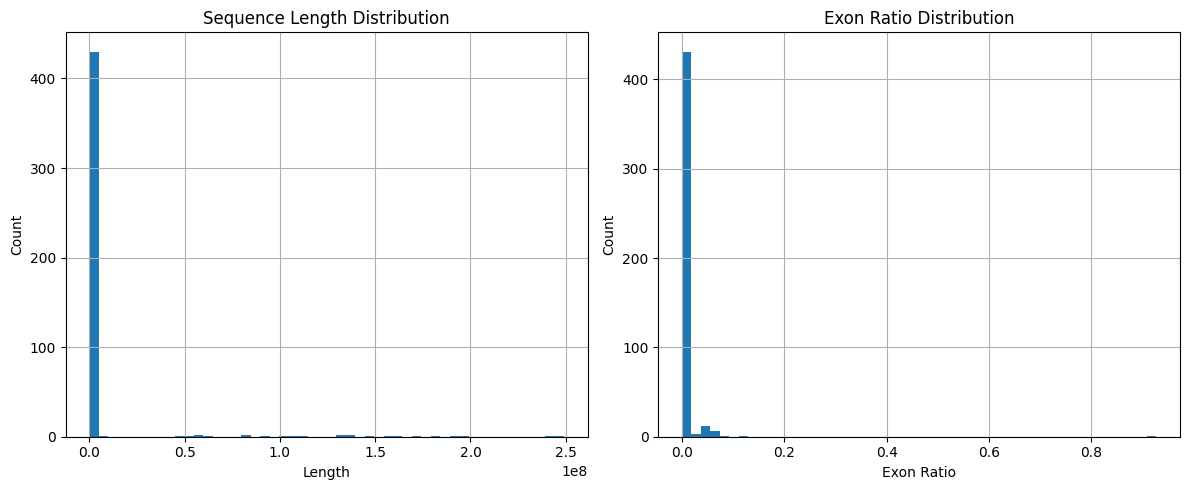

In [14]:
# Plot distributions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df["seq_len"].hist(bins=50)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")

plt.subplot(1,2,2)
df["exon_ratio"].hist(bins=50)
plt.title("Exon Ratio Distribution")
plt.xlabel("Exon Ratio")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [15]:
# Chromosome names overview
chr_counts = df["chr"].value_counts().sort_index()
print("Unique chromosome names (sorted):")
print(chr_counts.index.tolist())
print("\nCounts per chromosome:")
print(chr_counts)

Unique chromosome names (sorted):
['chr1', 'chr10', 'chr10_GL383545v1_alt', 'chr10_GL383546v1_alt', 'chr10_KI270824v1_alt', 'chr10_KI270825v1_alt', 'chr11', 'chr11_GL383547v1_alt', 'chr11_JH159136v1_alt', 'chr11_JH159137v1_alt', 'chr11_KI270721v1_random', 'chr11_KI270826v1_alt', 'chr11_KI270827v1_alt', 'chr11_KI270829v1_alt', 'chr11_KI270830v1_alt', 'chr11_KI270831v1_alt', 'chr11_KI270832v1_alt', 'chr11_KI270902v1_alt', 'chr11_KI270903v1_alt', 'chr11_KI270927v1_alt', 'chr12', 'chr12_GL383549v1_alt', 'chr12_GL383550v2_alt', 'chr12_GL383551v1_alt', 'chr12_GL383552v1_alt', 'chr12_GL383553v2_alt', 'chr12_GL877875v1_alt', 'chr12_GL877876v1_alt', 'chr12_KI270833v1_alt', 'chr12_KI270834v1_alt', 'chr12_KI270835v1_alt', 'chr12_KI270836v1_alt', 'chr12_KI270837v1_alt', 'chr12_KI270904v1_alt', 'chr13', 'chr13_KI270838v1_alt', 'chr13_KI270839v1_alt', 'chr13_KI270840v1_alt', 'chr13_KI270841v1_alt', 'chr13_KI270842v1_alt', 'chr13_KI270843v1_alt', 'chr14', 'chr14_GL000009v2_random', 'chr14_GL000194v1_

In [16]:
# Base-level class distribution (0 vs 1) overall and by chromosome
# Overall
total_ones = df["mask_ones"].sum()
total_bases = df["seq_len"].sum()
total_zeros = total_bases - total_ones
print(f"Overall bases: {total_bases:,} | exon(1): {total_ones:,} ({total_ones/total_bases:.2%}) | intron(0): {total_zeros:,} ({total_zeros/total_bases:.2%})")

# Per chromosome
per_chr = df.groupby("chr").agg(total_len=("seq_len","sum"), ones=("mask_ones","sum"))
per_chr["zeros"] = per_chr["total_len"] - per_chr["ones"]
per_chr["exon_ratio"] = per_chr["ones"] / per_chr["total_len"]
print("\nPer-chromosome base-level distribution:")
print(per_chr.sort_index())

Overall bases: 3,209,286,105 | exon(1): 150,621,766 (4.69%) | intron(0): 3,058,664,339 (95.31%)

Per-chromosome base-level distribution:
                        total_len      ones      zeros  exon_ratio
chr                                                               
chr1                    248956422  14078513  234877909    0.056550
chr10                   133797422   5853690  127943732    0.043750
chr10_GL383545v1_alt       179254         0     179254    0.000000
chr10_GL383546v1_alt       309802         0     309802    0.000000
chr10_KI270824v1_alt       181496         0     181496    0.000000
...                           ...       ...        ...         ...
chrX_KI270880v1_alt        284869         0     284869    0.000000
chrX_KI270881v1_alt        144206         0     144206    0.000000
chrX_KI270913v1_alt        274009         0     274009    0.000000
chrY                     57227415    738146   56489269    0.012898
chrY_KI270740v1_random      37240         0      37240    0

Sequence-level class counts:
label_majority
majority_0    454
majority_1      1
Name: count, dtype: int64


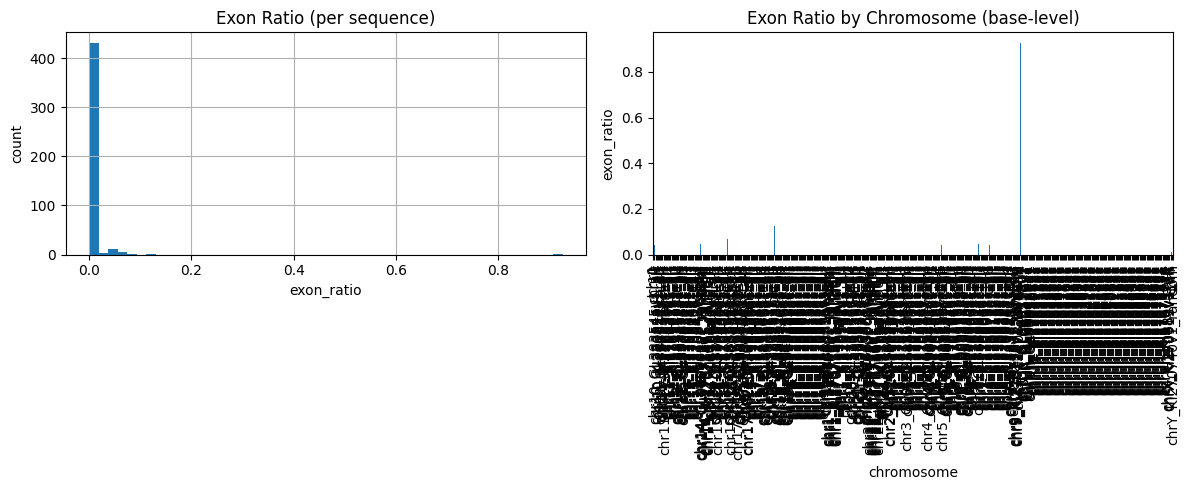

In [17]:
# Sequence-level class distribution (by majority class label per sequence)
df["label_majority"] = (df["exon_ratio"] >= 0.5).astype(int)
seq_counts = df["label_majority"].value_counts().rename(index={0:"majority_0",1:"majority_1"})
print("Sequence-level class counts:")
print(seq_counts)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12,5))
df["exon_ratio"].hist(bins=50, ax=axes[0])
axes[0].set_title("Exon Ratio (per sequence)")
axes[0].set_xlabel("exon_ratio")
axes[0].set_ylabel("count")

per_chr["exon_ratio"].plot(kind="bar", ax=axes[1])
axes[1].set_title("Exon Ratio by Chromosome (base-level)")
axes[1].set_xlabel("chromosome")
axes[1].set_ylabel("exon_ratio")
plt.tight_layout()
plt.show()

In [18]:
# Quick QC checks for masks
import re
only_01 = all(re.fullmatch(r"[01]+", m) is not None for m in df["mask"])
print("Masks contain only 0/1:", only_01)
assert only_01, "Found non-binary characters in masks"

Masks contain only 0/1: True
